# Visibility Simulator Examples

Although ``hera_sim`` is primarily aimed at simulating instrumental effects _on top_ of existing visibility simulations, it also provides a neat interface to several visibility simulators.

It does so through the base class ``VisibilitySimulator``, which sets a standard API from which all simulators must derive.

## VisCPU

In [1]:
from hera_sim.visibilities import VisCPU, HealVis
from hera_sim import io
import numpy as np
import healpy
import matplotlib.pyplot as plt
import itertools
from pyuvsim.analyticbeam import AnalyticBeam

from copy import deepcopy

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def plot_blts(simulator):
    fig, ax = plt.subplots(2, 1, sharex=True, 
                           subplot_kw={"ylabel":"|Visibility| [Jy]"})

    for i in simulator.uvdata.antenna_numbers:
        auto_ind = uvdata.antpair2ind((i,i))

        ax[0].plot(np.unique(uvdata.lst_array), np.abs(simulator.uvdata.data_array[auto_ind, 0, 0, 0]), label="ant_{}".format(i))

        for j in simulator.uvdata.antenna_numbers[(i+1):]:
            cross_ind = uvdata.antpair2ind((i,j))
            ax[1].plot(np.unique(uvdata.lst_array), np.abs(simulator.uvdata.data_array[cross_ind, 0, 0, 0]), label="bl({},{})".format(i,j))

    ax[0].legend()
    ax[1].legend()
    ax[0].set_title("Autocorrelations")
    ax[1].set_title("Cross-Correlations")
    ax[1].set_xlabel("LST");

``VisCPU`` natively deals with diffuse emission, and the ``VisibilitySimulator`` uses ``healpix`` maps to represent such emission:

In [3]:
NSIDE = 2**5
NPIX = 12 * NSIDE**2 # this is the number of pixels a healpix map has for  given NSIDE

# Create a pure white noise sky
sky_intensity = np.array([np.random.normal(100, 0.01, size=NPIX)]*5)

Other than the sky model (we'll revisit this soon), the ``VisibilitySimulator`` requires a ``UVData`` object to specify the observation parameters, as well as a list of ``UVBeam``s to specify the beams for each antenna. This makes it fully consistent with the interface provided by ``pyuvsim``, and many of the methods found in ``pyuvsim`` for creating ``UVData`` objects and ``UVBeam`` objects from YAML specifications can be used here. Indeed, a dictionary of so-called ``obsparams``, or a file-name for an appropriate YAML file, can be passed in lieu of the ``UVData`` and ``UVBeam``. 

For simplicity, let us simply use the native ``empty_uvdata`` function instead:

In [4]:
uvdata = io.empty_uvdata(
    nfreq = 5,
    ntimes= 10,
    ants = {
        0: (0,0,0),
        1: (20,20,0),
        2: (-20,20,0),
    },
    antpairs = sum([[(a,b) for a in range(3)] for b in range(3)], [])
)

In [5]:
simulator = VisCPU(
    uvdata = deepcopy(uvdata),
    sky_intensity = sky_intensity,
    sky_freqs = np.unique(uvdata.freq_array),
)

In [6]:
vis = simulator.simulate()

invalid value encountered in sqrt


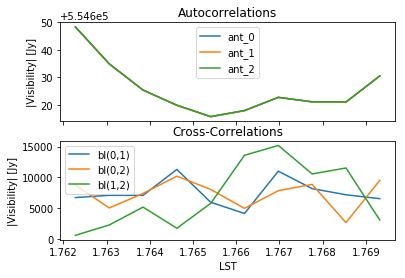

In [7]:
plot_blts(simulator)

In this, the beam was not set, and therefore the beam was assumed to be unity everywhere above the horizon. The beam can be set as a series of healpix maps, one for each antenna. 
An extra list of ``beam_ids`` specifies which of the beams each antenna uses. So, we can create something like a Gaussian beam:

In [8]:
simulator = VisCPU(
    uvdata = deepcopy(uvdata),
    sky_intensity = sky_intensity,
    sky_freqs = np.unique(uvdata.freq_array),
    beams = [AnalyticBeam("gaussian", diameter=14)]
)

In [9]:
vis = simulator.simulate()

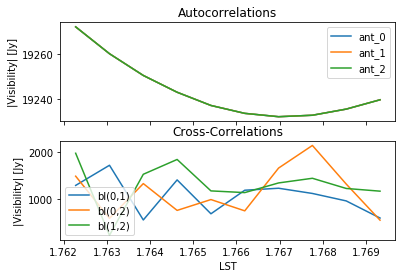

In [10]:
plot_blts(simulator)

## HealVis

We could also have used healvis for this:

In [11]:
simulator = HealVis(
    uvdata = deepcopy(uvdata),
    sky_freqs = uvdata.freq_array[0],
    sky_intensity = sky_intensity,
)

In [12]:
vis = simulator.simulate()

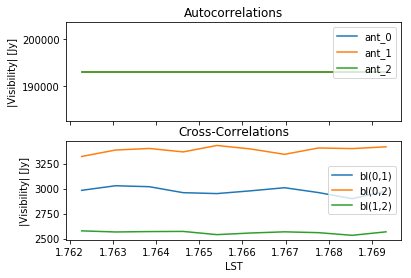

In [13]:
fig, ax = plt.subplots(2, 1, sharex=True, 
                       subplot_kw={"ylabel":"|Visibility| [Jy]"})

for i in range(3):
    auto_ind = uvdata.antpair2ind((i,i))
    
    ax[0].plot(np.unique(uvdata.lst_array), np.abs(simulator.uvdata.data_array[auto_ind, 0, 0, 0]), label="ant_{}".format(i))
    
    for j in range(3)[(i+1):]:
        cross_ind = uvdata.antpair2ind((i,j))
        ax[1].plot(np.unique(uvdata.lst_array), np.abs(simulator.uvdata.data_array[cross_ind, 0, 0, 0]), label="bl({},{})".format(i,j))

ax[0].legend()
ax[1].legend()
ax[0].set_title("Autocorrelations")
ax[1].set_title("Cross-Correlations")
ax[1].set_xlabel("LST");